code_name: CSS
codes_and_size: ['Planar 6x6']
Error model: Biased-depolarizing (bias=10, axis='Z')
Decoder: Planar MPS_def (chi=12, mode=c)
Error probabilities: [0.01       0.05333333 0.09666667 0.14       0.18333333 0.22666667
 0.27       0.31333333 0.35666667 0.4       ]
Maximum runs: 5000
[[0.0, 0.0], [0.017, 0.0018281684823888635], [0.097, 0.004185474883451099], [0.2238, 0.005894294868769291], [0.3564, 0.006773168239457809], [0.445, 0.007028157653325656], [0.4692, 0.0070576392653634535], [0.4862, 0.007068374070463448], [0.4992, 0.007071058760892883], [0.516, 0.0070674464978519634]]


/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: divide by zero encountered in log
/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars


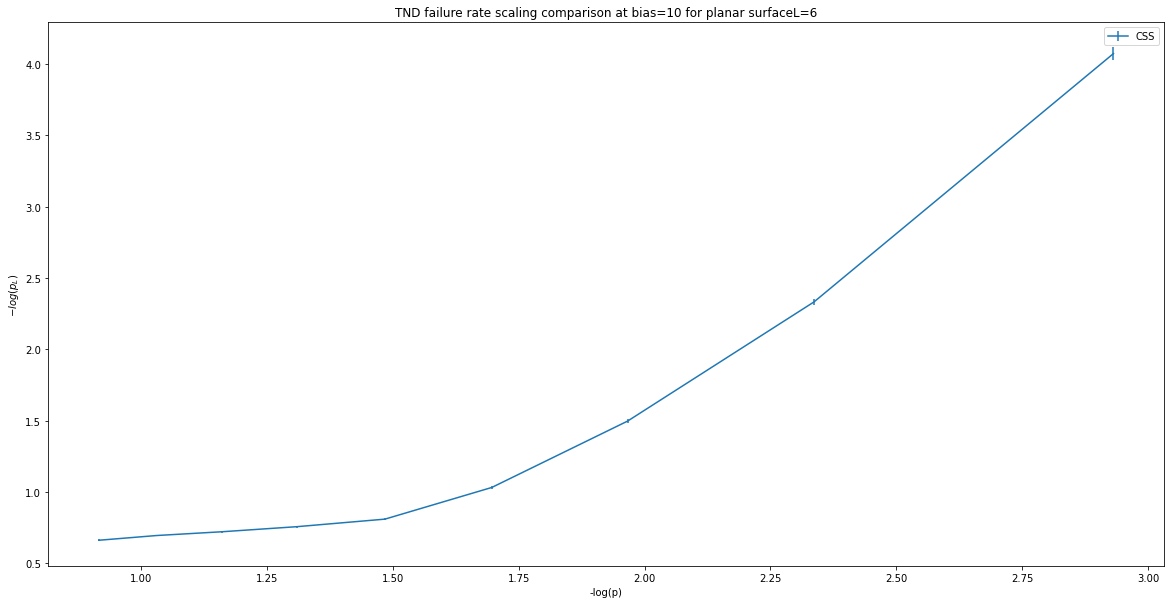

In [2]:
import collections
import itertools
import numpy as np
from qecsim import paulitools as pt
import matplotlib.pyplot as plt
import qecsim
from qecsim import app
from qecsim.models.generic import PhaseFlipErrorModel,DepolarizingErrorModel,BiasedDepolarizingErrorModel,BiasedYXErrorModel
from qecsim.models.planar import PlanarCode,PlanarMPSDecoder
# from _planarmpsdecoder_def import PlanarMPSDecoder_def
import app_def
import _planarmpsdecoder_def
import importlib as imp
imp.reload(app_def)
imp.reload(_planarmpsdecoder_def)
import os,time
import multiprocessing as mp
from functools import partial



def parallel_step_p(code,error_model,decoder,max_runs,perm_rates,code_name,error_probability):
    # perm_mat,perm_vec= deform_matsvecs(code,decoder,error_model)
    result= app_def.run_def(code,error_model,decoder,error_probability,perm_rates,code_name,max_runs)
    return result

def parallel_step_code(code,error_model,decoder,max_runs,perm_rates,code_name,error_probabilities,realization_index):

    pL_list=np.zeros((len(error_probabilities)))
    std_list=np.zeros((len(error_probabilities)))  

    # perm_mat,perm_vec= deform_matsvecs(code,decoder,error_model)
    for error_probability_index,error_probability in enumerate(error_probabilities):
        # perm_mat,perm_vec= deform_matsvecs(code,decoder,error_model)
        [pL_list[error_probability_index],std_list[error_probability_index]]= app_def.run_def(code,error_model,decoder,error_probability,perm_rates,code_name,max_runs)

    return [pL_list,std_list]

def TNDresult(code,decoder,error_model,max_runs,perm_rates,error_probabilities,code_name,num_realiz):
    pL_list_realiz=np.zeros((num_realiz,len(error_probabilities)))
    std_list_realiz=np.zeros((num_realiz,len(error_probabilities)))      
    
    pL_list=np.zeros(len(error_probabilities))
    std_list=np.zeros(len(error_probabilities))
    log_pL_list=np.zeros(len(error_probabilities))
    log_std_list=np.zeros(len(error_probabilities))
    
    if code_name=='random_all' or code_name=='random_XZ' or code_name=='random_XZ_YZ':
        p=mp.Pool()
        func=partial(parallel_step_code,code,error_model,decoder,max_runs,perm_rates,code_name,error_probabilities)
        result=p.map(func,range(num_realiz))
        #print(result)
        p.close()
        p.join()
        for realization_index in range(num_realiz):
            for i in range(len(error_probabilities)):
                pL_list_realiz[realization_index][i]=result[realization_index][0][i]
                std_list_realiz[realization_index][i]=result[realization_index][1][i]
        
        pL_list = np.sum(pL_list_realiz,axis=0)/num_realiz
        std_list = np.sqrt(np.sum(vsquare(std_list_realiz),axis=0))/num_realiz

        for i in range(len(pL_list)):
            log_pL_list[i]=-np.log(pL_list[i])
            log_std_list[i]=std_list[i]/(pL_list[i]*np.log(10))

    else:
        p=mp.Pool()
        func=partial(parallel_step_p,code,error_model,decoder,max_runs,perm_rates,code_name)
        result=p.map(func,error_probabilities)
        print(result)
        p.close()
        p.join()
        
        for i in range(len(result)):
            pL_list[i]=result[i][0]   
            std_list[i]=result[i][1]
            log_pL_list[i]=-np.log(pL_list[i])
            log_std_list[i]=std_list[i]/(pL_list[i]*np.log(10))

    return [pL_list,std_list,log_pL_list,log_std_list]




if __name__=='__main__':

    def square(a):
        return a**2
    vsquare=np.vectorize(square)
    layout_name="planar"
    bdry_name='surface'

    sizes= range(6,7,2)
    codes_and_size = [PlanarCode(*(size,size)) for size in sizes]
    p_min,p_max=0.01,0.40
    error_probabilities=np.linspace(p_min,p_max,10)

    #export data
    timestr=time.strftime("%Y%m%d-%H%M%S")   #record current date and time
    import os
    dirname="./data/"+'all_codes'+timestr
    os.mkdir(dirname)    #make a new directory with current date and time  

    # code_names=['spiral_XZ','random_XZ','random_XZ_YZ','random_XY']

    bias_list=[10]
    code_names=['CSS']

    # bias_list=[300]
    # # code_names=['spiral_XZ','random_XZ','random_all','random_XY']
    # # code_names=['CSS','XZZX','spiral_XZ','random_XZ','random_all','XY','random_XY']
    # code_names=['XY','CSS']
    for L_index,code in enumerate(codes_and_size):
        for bias in bias_list:
            from itertools import cycle
            plt.figure(figsize=(20,10))
            lines=["-",":","--","-."]
            linecycler=cycle(lines)
            plt.title('TND failure rate scaling comparison at bias='+str(bias)[:7]+' for '+layout_name+' '+bdry_name+'L='+str(sizes[L_index]))

            for code_name in code_names:
                if code_name=='CSS':
                    num_realiz=1
                    bias_str='Z'
                    max_runs=5000
                elif code_name=='XY':
                    bias_str='Y'
                    num_realiz=1
                    max_runs=20000
                elif code_name=='XZZX':
                    num_realiz=1
                    bias_str='Z'
                    max_runs=20000
                elif code_name=='spiral_XZ':
                    num_realiz=1
                    bias_str='Z'
                    max_runs=20000
                elif code_name=='random_XZ_YZ':
                    num_realiz=40
                    bias_str='Z'
                    max_runs=2000
                    perm_rates=[1/3,1/3,1/3,0,0,0]
                elif code_name=='random_all':
                    num_realiz=40
                    bias_str='Z'
                    max_runs=2000
                    perm_rates=[1/6,1/6,1/6,1/6,1/6,1/6]                    
                elif code_name=='random_XZ':
                    num_realiz=40
                    bias_str='Z'
                    max_runs=2000
                    perm_rates=[1/2,1/2,0,0,0,0]
                elif code_name=='random_XY':
                    num_realiz=1
                    bias_str='Z'
                    max_runs=5000
                    perm_rates=[1/2,0,0,0,1/2,0]

                error_model = BiasedDepolarizingErrorModel(bias,bias_str)
                # bias=1/bias
                # error_model=BiasedYXErrorModel(bias)
                chi_val=12
                decoder = _planarmpsdecoder_def.PlanarMPSDecoder_def(chi=chi_val)
               
                # print run parameters
                print('code_name:',code_name)
                print('codes_and_size:',[code.label for code in codes_and_size])
                print('Error model:',error_model.label)
                print('Decoder:',decoder.label)
                print('Error probabilities:',error_probabilities)
                print('Maximum runs:',max_runs)
                [pL_list,std_list,log_pL_list,log_std_list]=TNDresult(code,decoder,error_model,max_runs,perm_rates,error_probabilities,code_name,num_realiz)

                np.savetxt(dirname+"/p_list"+code_name+str(bias)[:7]+".csv",error_probabilities,delimiter=",")
                np.savetxt(dirname+"/pL_list"+code_name+str(bias)[:7]+".csv",pL_list,delimiter=",")
                np.savetxt(dirname+"/std_list"+code_name+str(bias)[:7]+".csv",std_list,delimiter=",")

                plt.errorbar(-np.log(error_probabilities),log_pL_list,log_std_list)

            plt.xlabel('-log(p)')
            plt.ylabel('$-log(p_L)$')
            plt.legend(code_names) 
            plt.savefig(dirname+"/scaling_code_comparison_bias="+str(bias)[:7]+".pdf")




In [3]:






code_name: random_XY
codes_and_size: ['Planar 6x6']
Error model: Biased-depolarizing (bias=10, axis='Z')
Decoder: Planar MPS_def (chi=12, mode=c)
Error probabilities: [0.01       0.05333333 0.09666667 0.14       0.18333333 0.22666667
 0.27       0.31333333 0.35666667 0.4       ]
Maximum runs: 5000
[[0.0, 0.0], [0.0192, 0.0019406885376072069], [0.1018, 0.004276371358991172], [0.2332, 0.005980263539343396], [0.3644, 0.0068060655300988685], [0.4288, 0.006999007929699751], [0.4844, 0.007067625343777074], [0.492, 0.007070162657251953], [0.5106, 0.007069478622925456], [0.4948, 0.0070706853981774625]]


SyntaxError: invalid syntax (<ipython-input-3-5b12e028f56e>, line 3)

In [5]:
result=[[0.0, 0.0], [0.0192, 0.0019406885376072069], [0.1018, 0.004276371358991172], [0.2332, 0.005980263539343396], [0.3644, 0.0068060655300988685], [0.4288, 0.006999007929699751], [0.4844, 0.007067625343777074], [0.492, 0.007070162657251953], [0.5106, 0.007069478622925456], [0.4948, 0.0070706853981774625]]


In [6]:
        for i in range(len(result)):
            pL_list[i]=result[i][0]   
            std_list[i]=result[i][1]
            log_pL_list[i]=-np.log(pL_list[i])
            log_std_list[i]=std_list[i]/(pL_list[i]*np.log(10))

/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
/opt/sagemath-9.2/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


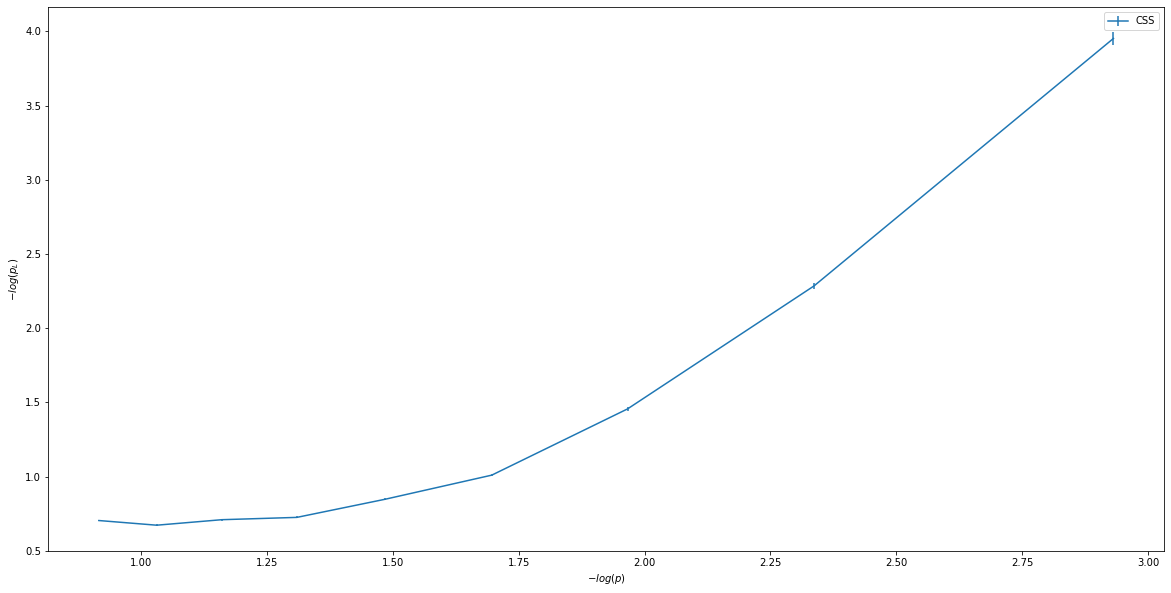

In [7]:
plt.figure(figsize=(20,10))
lines=["-",":","--","-."]
linecycler=cycle(lines)
        
plt.errorbar(-np.log(error_probabilities),log_pL_list,log_std_list)

plt.xlabel('$-log(p)$')
plt.ylabel('$-log(p_L)$')
plt.legend(code_names) 
plt.savefig("scaling_code_comparison_bias="+str(bias)[:7]+".pdf")